# Setup

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
df = pd.read_csv("cardio_train.csv", sep=";")



# Clean data

In [54]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

if 'cardio' in df:
    y = df['cardio'].values
    del df['cardio']
    X = df.values


# Model Variable Selection Options

1. 'ap_hi' (highest co-relation)
2. 'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
3. 'bmi', 'age', ‘bp’, 'cholesterol'
4. ‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol'
5. 'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active', 'weight' (all variable)



## train test split

In [55]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model (ap_hi only)

### Not Scaled

In [56]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73178013 0.72675255 0.7366475 ]


### Scaled

In [57]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73730664 0.73165566 0.73780694]


## SVM using weight, age, ap_lo, ap_hi, cholesterol

### Not Scaled

In [58]:
X = df[['ap_hi', 'ap_lo', 'weight', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.51702548 0.69087998 0.55910745]


### Scaled

In [59]:
X = df[['ap_hi', 'ap_lo', 'weight', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77688161 0.76810021 0.76476651]


## SVM using BMI, age, ap_hi, ap_lo, cholesterol

### Not Scaled

In [60]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.49432154 0.72373225 0.52917342]


### Scaled

In [61]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.7813159  0.76830538 0.77036236]


## SVM using categorical blood pressure bins

### Not Scaled

In [62]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.629648   0.63755937 0.67819507]


### Scaled

In [63]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

numeric_features = ['age', 'bmi']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.75153538 0.74223173 0.74142001]


## SVM bmi, age, ap_lo, ap_hi, cholesterol, gluc, smoke, alco, active, weight

### Not Scaled

In [64]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77015474 0.77798806 0.77734464]


### Scaled

In [65]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77629988 0.75975616 0.76673131]


# Hyperparameter Tuning

In [66]:
from sklearn.model_selection import GridSearchCV

### SVM

In [67]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',


In [68]:
clf.best_params_

{'classifier__alpha': 0.05,
 'classifier__loss': 'modified_huber',
 'classifier__penalty': 'elasticnet'}

In [69]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


Best auc: 0.777657 using {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.774494 (0.001932) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.772713 (0.004164) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.774224 (0.002725) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776813 (0.001649) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.776193 (0.001936) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.777448 (0.001209) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.777499 (0.001308) with: {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.7773

## Probability Calibration

In [70]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.78158752 0.77803967 0.78229531]


## ROC

SVM Model ROC AUC=0.775


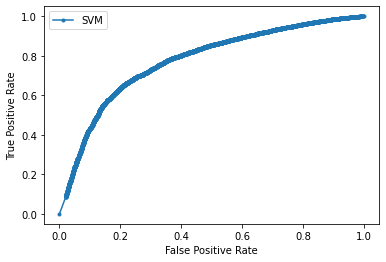

In [71]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [72]:
svm_probs

array([0.62397217, 0.2512819 , 0.68512204, ..., 0.29151304, 0.95314928,
       0.35823854])

In [73]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))


alpha 0.000000 : accuracy=0.561
alpha 0.100000 : accuracy=0.561
alpha 0.200000 : accuracy=0.565
alpha 0.300000 : accuracy=0.618
alpha 0.400000 : accuracy=0.699
alpha 0.500000 : accuracy=0.716
alpha 0.600000 : accuracy=0.689
alpha 0.700000 : accuracy=0.627
alpha 0.800000 : accuracy=0.563
alpha 0.900000 : accuracy=0.513


### tune a little finer

In [74]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



alpha 0.400000 : accuracy=0.699
alpha 0.410000 : accuracy=0.704
alpha 0.420000 : accuracy=0.708
alpha 0.430000 : accuracy=0.713
alpha 0.440000 : accuracy=0.718
alpha 0.450000 : accuracy=0.719
alpha 0.460000 : accuracy=0.718
alpha 0.470000 : accuracy=0.716
alpha 0.480000 : accuracy=0.716
alpha 0.490000 : accuracy=0.715
alpha 0.500000 : accuracy=0.716
alpha 0.510000 : accuracy=0.715
alpha 0.520000 : accuracy=0.715
alpha 0.530000 : accuracy=0.713
alpha 0.540000 : accuracy=0.712
alpha 0.550000 : accuracy=0.708
alpha 0.560000 : accuracy=0.704
alpha 0.570000 : accuracy=0.701
alpha 0.580000 : accuracy=0.697
alpha 0.590000 : accuracy=0.694


# All the below is not currently applicable

# Most Useful Variables

## Look at Support Vectors

In [47]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)


#scale
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7121973695233308
[[16425  4581]
 [ 9161 17581]]


In [48]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(3552, 13)
(3552,)
[1777 1775]


[[-0.00360324  0.10440692 -0.01069967 -0.16460268  0.3582464   1.15765979
   0.14242914  0.35304275 -0.04852486 -0.01851078 -0.01373462 -0.0387172
  -0.29033337]]


<AxesSubplot:>

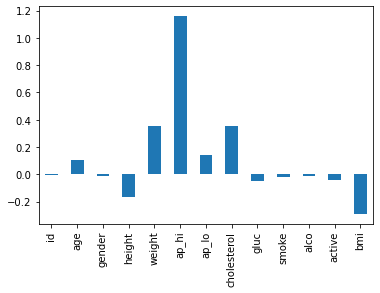

In [50]:
# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')

In [69]:
df = pd.read_csv("/Users/tina/Documents/School/ML1/SMUMSDS-ML1/cardio_train.csv", sep=";")

df = df[df["weight"] < 200]
df = df[df["weight"] > 55]
df = df[df["height"] < 200]
df = df[df["height"] > 130]
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

df['bmi'] = df['weight'] / (df['height']/100)**2

if 'cardio' in df:
    y = df['cardio'].values # get the labels we want
    del df['cardio'] # get rid of the class label
    X = df.values # use everything else to predict!
    
cv_object =  ShuffleSplit(n_splits=1,
                         test_size  = 0.9)

#train test split
for train_indices, test_indices in cv_object.split(X, y):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    scl_obj = StandardScaler()
    scl_obj.fit(X_train)
    
    X_train_scaled = scl_obj.transform(X_train)
    X_test_scaled = scl_obj.transform(X_test) 
        

# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
    
# make a dataframe of the training data
df_tested_on = df.iloc[train_indices].copy() # saved from above, the indices chosen for training

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['cardio'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df['cardio'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3542 entries, 11650 to 62503
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3542 non-null   int64  
 1   age          3542 non-null   int64  
 2   gender       3542 non-null   int64  
 3   height       3542 non-null   int64  
 4   weight       3542 non-null   float64
 5   ap_hi        3542 non-null   int64  
 6   ap_lo        3542 non-null   int64  
 7   cholesterol  3542 non-null   int64  
 8   gluc         3542 non-null   int64  
 9   smoke        3542 non-null   int64  
 10  alco         3542 non-null   int64  
 11  active       3542 non-null   int64  
 12  bmi          3542 non-null   float64
 13  cardio       3542 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 415.1 KB


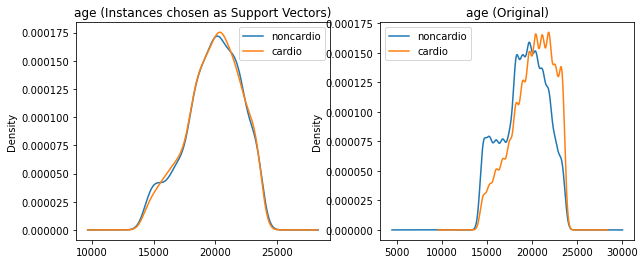

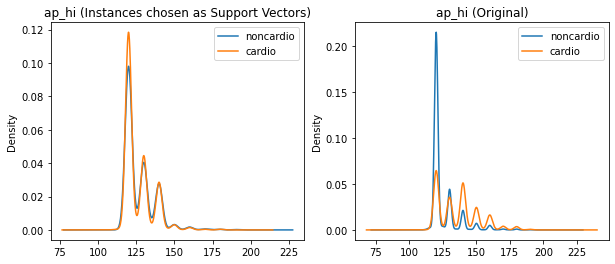

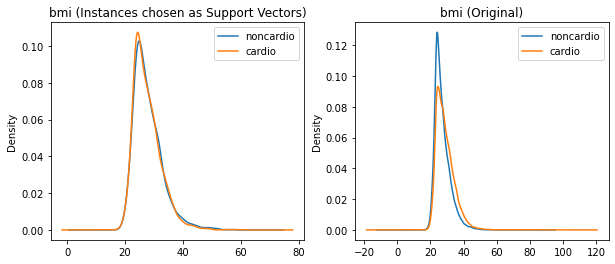

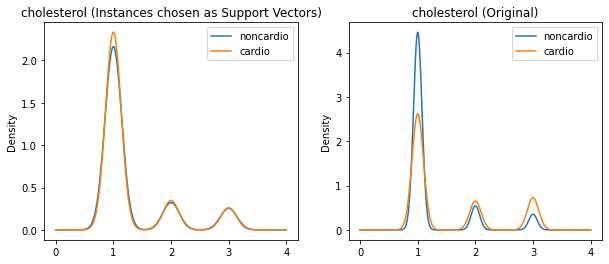

In [70]:

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df.groupby(['cardio'])

# plot KDE of Different variables
vars_to_plot = ['age','ap_hi','bmi','cholesterol']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['noncardio','cardio'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['noncardio','cardio'])
    plt.title(v+' (Original)')




## pca

In [75]:
%%time
# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components = 10

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 500
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', max_iter=iterations, n_jobs=-1, penalty='l2')

# you could also set this up in a pipeline
for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.5303258775236659
CPU times: user 333 ms, sys: 35.7 ms, total: 369 ms
Wall time: 226 ms
